In [1]:
import os
import time
import json
import asyncio
import datetime

import sys
sys.path.append('/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/')

from style_utils import load_vgg_model, load_and_preprocess_images, GramMatrix, weighted_style_correlation, load_and_preprocess_png

from vertexai.generative_models import GenerativeModel, Part
from src.tools.serp import search as google_search
from src.tools.segment import segment_image 
from src.tools.segmentation_eval import segmentation_evaluator
from src.tools.oneshot_segGPT import seggpt_inference_img
from src.tools.mitonet import mitonet_inference

/home/idies/workspace/Storage/xyu1/persistent/pytorch_env/Langchain/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/idies/workspace/Storage/xyu1/persistent/pytorch_env/Langchain/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/idies/workspace/Storage/xyu1/persistent/pytorch_env/Langchain/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/Scenario_Improving/style_utils.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.l

Execution time: 1.0951 seconds


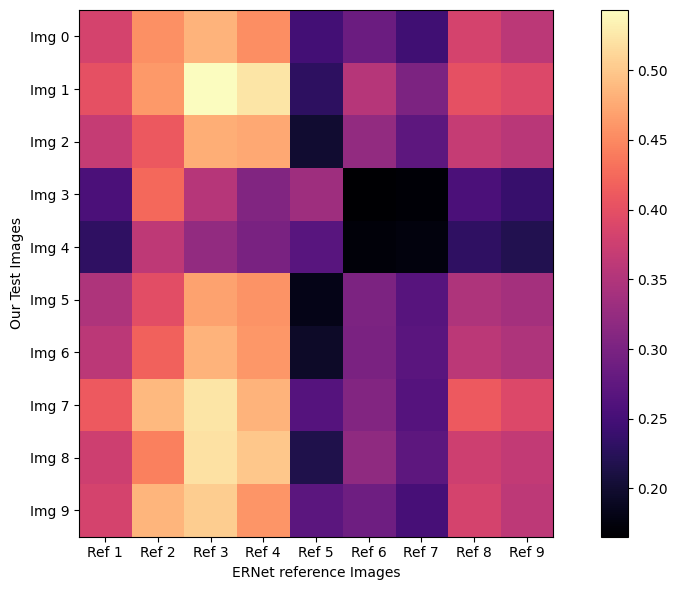

In [2]:
import matplotlib.pyplot as plt 
from PIL import Image
import numpy as np
import time

# Start timer
start_time = time.time()

# Constants
output_dir = "./ERNet_results"
model_path = "/home/idies/workspace/Storage/xyu1/persistent/micro-sam/finetuning/PytorchNeuralStyleTransfer/Models/vgg_conv.pth"
style_layers = ['r11','r21','r31','r41', 'r51']
style_weights = [1.0] * len(style_layers)

vgg = load_vgg_model(model_path)

def extract_features(image_path):
    img_name = os.path.basename(image_path)
    image_tensor = load_and_preprocess_png(os.path.dirname(image_path) + "/", [img_name])[0]
    features = [GramMatrix()(f).detach() for f in vgg(image_tensor, style_layers)]
    return features

prompt_sets = [
    {
        "name": "ERNet_reference_1",
        "image": "/home/idies/workspace/Storage/xyu1/persistent/ERnet-v2/crop_ernet_input_1.png",
        "mask":  "/home/idies/workspace/Storage/xyu1/persistent/ERnet-v2/crop_ernet_output_1.png"
    },
    {
        "name": "ERNet_reference_2",
        "image": "/home/idies/workspace/Storage/xyu1/persistent/ERnet-v2/crop_ernet_input_2.png",
        "mask":  "/home/idies/workspace/Storage/xyu1/persistent/ERnet-v2/crop_ernet_output_2.png"
    },
    {
        "name": "ERNet_reference_3",
        "image": "/home/idies/workspace/Storage/xyu1/persistent/ERnet-v2/crop_ernet_input_3.png",
        "mask":  "/home/idies/workspace/Storage/xyu1/persistent/ERnet-v2/crop_ernet_output_3.png"
    },
    {
        "name": "ERNet_reference_4",
        "image": "/home/idies/workspace/Storage/xyu1/persistent/ERnet-v2/crop_ernet_input_4.png",
        "mask":  "/home/idies/workspace/Storage/xyu1/persistent/ERnet-v2/crop_ernet_output_4.png"
    },
    {
        "name": "ERNet_reference_5",
        "image": "/home/idies/workspace/Storage/xyu1/persistent/ERnet-v2/crop_ernet_input_5.png",
        "mask":  "/home/idies/workspace/Storage/xyu1/persistent/ERnet-v2/crop_ernet_output_5.png"
    },
    {
        "name": "ERNet_reference_6",
        "image": "/home/idies/workspace/Storage/xyu1/persistent/ERnet-v2/crop_ernet_input_6.png",
        "mask":  "/home/idies/workspace/Storage/xyu1/persistent/ERnet-v2/crop_ernet_output_6.png"
    },
    {
        "name": "ERNet_reference_7",
        "image": "/home/idies/workspace/Storage/xyu1/persistent/ERnet-v2/crop_ernet_input_7.png",
        "mask":  "/home/idies/workspace/Storage/xyu1/persistent/ERnet-v2/crop_ernet_output_7.png"
    },
    {
        "name": "ERNet_reference_8",
        "image": "/home/idies/workspace/Storage/xyu1/persistent/ERnet-v2/crop_ernet_input_8.png",
        "mask":  "/home/idies/workspace/Storage/xyu1/persistent/ERnet-v2/crop_ernet_output_8.png"
    },
    {
        "name": "ERNet_reference_9",
        "image": "/home/idies/workspace/Storage/xyu1/persistent/ERnet-v2/crop_ernet_input_9.png",
        "mask":  "/home/idies/workspace/Storage/xyu1/persistent/ERnet-v2/crop_ernet_output_9.png"
    }
]


image_index_list = [1, 101, 109, 125, 171, 45, 49, 77, 85, 86]

base_img_path = "/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/test_images/er/images/image_{}.png"
base_label_path = "/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/test_images/er/labels/label_{}.png"


# Load images
val_images = [item["image"] for item in prompt_sets]
test_images = [base_img_path.format(idx) for idx in image_index_list]

# Extract features (define this function elsewhere or import it)
val_features = [extract_features(img) for img in val_images]
test_features = [extract_features(img) for img in test_images]

# Define your style_weights before this loop
# Example: style_weights = {"color": 0.3, "texture": 0.7}
# or however your weighted_style_correlation function is defined

scores = np.zeros((len(test_features), len(val_features)))  # 10x9

# Compute weighted correlation scores
for i, tf in enumerate(test_features):
    for j, vf in enumerate(val_features):
        scores[i, j] = weighted_style_correlation(vf, tf, style_weights)

# Convert to numpy array if needed
correlation_matrix = np.array(scores)
# End timer
end_time = time.time()
print(f"Execution time: {end_time - start_time:.4f} seconds")
# Display matrix
plt.figure(figsize=(10, 6))
plt.imshow(correlation_matrix, cmap='magma')
plt.colorbar()
plt.xlabel("ERNet reference Images")
plt.ylabel("Our Test Images")
plt.xticks(ticks=np.arange(9), labels=[f"Ref {i+1}" for i in range(9)])
plt.yticks(ticks=np.arange(10), labels=[f"Img {idx}" for idx in range(10)])
#plt.yticks(ticks=np.arange(10), labels=[f"Img {idx}" for idx in image_index_list])
#plt.title("Our Test Images vs ERNet reference Images Style Correlation")
plt.tight_layout()
#plt.savefig("correlation.svg", bbox_inches="tight", pad_inches=0.1)
plt.show()


In [4]:
input_filename = "endoplasmic_reticulum_visual_characteristics.json"

# Read the file
with open(input_filename, "r", encoding="utf-8") as f:
    data = json.load(f)

# Now you can use `data` like a regular Python dictionary
print(data)

result_dict = json.loads(data)

# Now extract the segmentation prompt
segmentation_prompt = result_dict["summary"]["segmentation_prompt"]
visual_characteristics = result_dict["summary"]["visual_characteristics"]

{
  "top_results": [
    {
      "position": 1,
      "title": "Endoplasmic reticulum (ER) | Definition, Function, & Location",
      "link": "https://www.britannica.com/science/endoplasmic-reticulum",
      "snippet": "Differences in certain physical and functional characteristics distinguish the two types of ER, known as rough ER and smooth ER."
    },
    {
      "position": 2,
      "title": "structure, function and response to cellular signaling",
      "link": "https://pmc.ncbi.nlm.nih.gov/articles/PMC4700099/",
      "snippet": "The ER consists of the nuclear envelope and the peripheral ER, which includes smooth tubules and rough sheets. While the ER is defined as an interconnected ..."
    },
    {
      "position": 3,
      "title": "Endoplasmic reticulum",
      "link": "https://en.wikipedia.org/wiki/Endoplasmic_reticulum",
      "snippet": "The endoplasmic reticulum is found in most eukaryotic cells and forms an interconnected network of flattened, membrane-enclosed sacs kno

In [5]:
# Function to calculate IoU
def calculate_iou(pred_mask, gt_mask):
    pred_binary = np.array(pred_mask) > 0
    gt_binary = np.array(gt_mask) > 0
    intersection = np.logical_and(pred_binary, gt_binary).sum()
    union = np.logical_or(pred_binary, gt_binary).sum()
    if union == 0:
        return float('nan')  # Avoid division by zero
    return intersection / union


Processing image_1...
ERNet IoU for image_1: 0.2416


2025-09-30 12:31:06,912 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Fidelity" (Weight: 0.3): 40,
    "Appearance Consistency" (Weight: 0.25): 50,
    "Object Completeness" (Weight: 0.25): 60,
    "Background Exclusion" (Weight: 0.2): 30,
    "OverallScore": 45.5
  },
  "Reasons": {
    "Shape Fidelity" (Weight: 0.3): "While the provided criterion specifies 'spherical or slightly varied lysosome shape,' this evaluation is for endoplasmic reticulum (ER). Interpreting shape fidelity for ER, the segmentation partially captures the elongated, cisternal forms. However, the contours are often jagged, irregular, and do not smoothly follow the ER membranes. Many small, scattered segmented regions are highly irregular and do not resemble typical ER morphology, significantly detracting from the score.",
    "Appearance Consistency" (Weight: 0.25): "The criterion mentions 'dense, dark, 'vacuole-like' structures,' but for ER, we look for consistency with the ER lumen and membranes. The larger segmented regions generally align with th

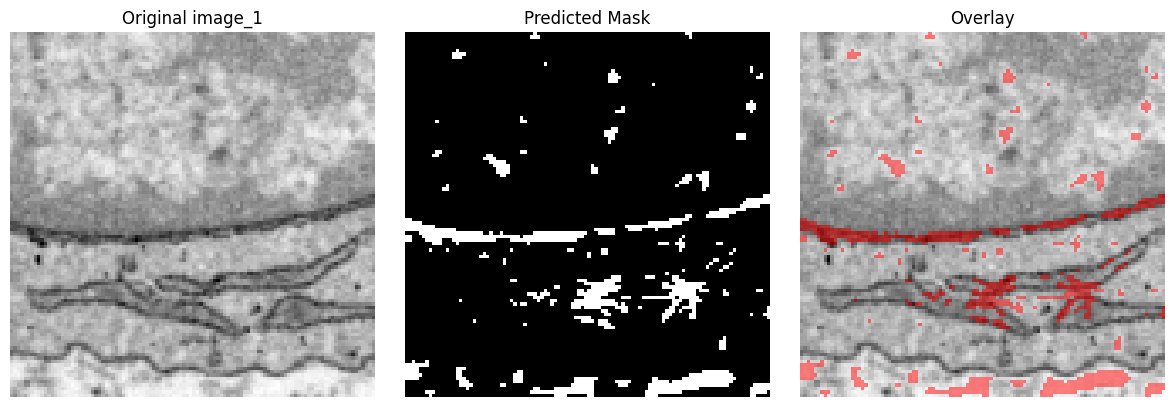


Processing image_101...
ERNet IoU for image_101: 0.0069


2025-09-30 12:32:14,360 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Fidelity" (Weight: 0.3): 5,
    "Appearance Consistency" (Weight: 0.25): 5,
    "Object Completeness" (Weight: 0.25): 0,
    "Background Exclusion" (Weight: 0.2): 5,
    "OverallScore": 3.75
  },
  "Reasons": {
    "Shape Fidelity" (Weight: 0.3): "The segmented regions are highly irregular, elongated, and often jagged, bearing no resemblance to the expected spherical or smoothly rounded lysosome shape. They appear to delineate internal membrane spaces of other organelles, not lysosomes.",
    "Appearance Consistency" (Weight: 0.25): "The segmented areas are typically lighter regions, representing lumens or intermembrane spaces, which is contrary to the expected dense, dark, 'vacuole-like' appearance of lysosomes. They do not look like filled, membrane-bound sacs.",
    "Object Completeness" (Weight: 0.25): "The segmentation completely fails to identify any structures resembling lysosomes. Instead, it segments other cellular components, primarily mitochon

/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/oneshot_segGPT.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chkpt_dir, m

One shot segmentation completed and saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/seggpt_results.png, the mask is saved in seggpt_mask_path:/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/seggpt_results_mask.png.
SegGPT IoU for image_101: 0.1914
→ SegGPT overlay saved to: ./ERNet_results/image_101_seggpt.png


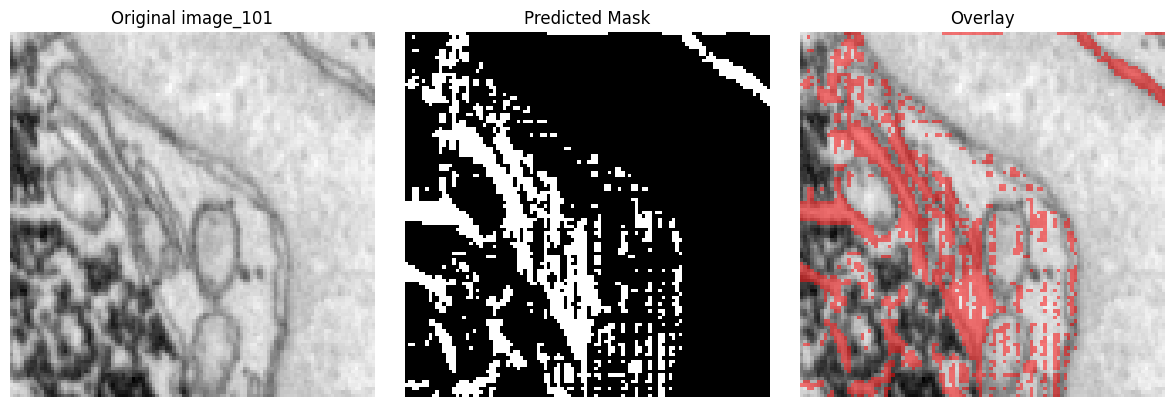


Processing image_109...
ERNet IoU for image_109: 0.0291


2025-09-30 12:33:00,518 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Fidelity" (Weight: 0.3): 10,
    "Appearance Consistency" (Weight: 0.25): 15,
    "Object Completeness" (Weight: 0.25): 5,
    "Background Exclusion" (Weight: 0.2): 40,
    "OverallScore": 16
  },
  "Reasons": {
    "Shape Fidelity" (Weight: 0.3): "The segmented regions are extremely fragmented, appearing as small, irregular specks and short lines. They do not form the characteristic tubular or cisternal network of the ER, nor do they exhibit smooth, continuous contours. The shapes are highly non-representative of ER morphology, which typically involves interconnected membranes rather than isolated dots.",
    "Appearance Consistency" (Weight: 0.25): "The segmented areas are mostly thin, scattered patches, often located near membrane structures. However, they do not consistently capture the internal appearance of ER lumen or its full membrane boundaries. Many segments are too small to assess internal consistency, and some appear to be on non-ER structure

/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/oneshot_segGPT.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chkpt_dir, m

One shot segmentation completed and saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/seggpt_results.png, the mask is saved in seggpt_mask_path:/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/seggpt_results_mask.png.
SegGPT IoU for image_109: 0.2234
→ SegGPT overlay saved to: ./ERNet_results/image_109_seggpt.png


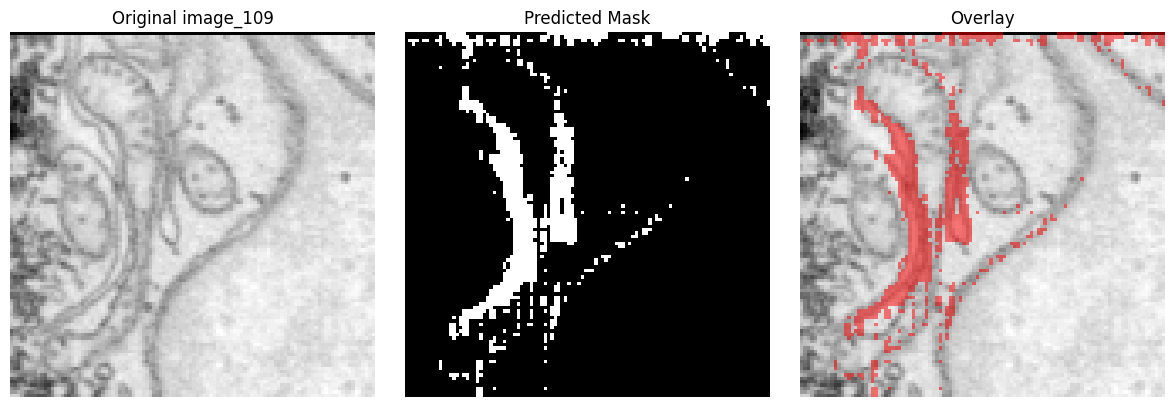


Processing image_125...
ERNet IoU for image_125: 0.0420


2025-09-30 12:33:44,250 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Fidelity" (Weight: 0.3): 10,
    "Appearance Consistency" (Weight: 0.25): 40,
    "Object Completeness" (Weight: 0.25): 5,
    "Background Exclusion" (Weight: 0.2): 20,
    "OverallScore": 18.25
  },
  "Reasons": {
    "Shape Fidelity" (Weight: 0.3): "The segmented regions are predominantly small, irregular, and fragmented patches. They do not accurately reflect the expected tubular or cisternal network morphology of the endoplasmic reticulum. The contours are often jagged and fail to smoothly delineate ER membranes.",
    "Appearance Consistency" (Weight: 0.25): "While many small segmented fragments are located within areas that visually correspond to ER structures (e.g., lumen or membrane-associated regions), the segmentation is highly fragmented and does not consistently represent the full internal appearance of the ER. A large segmented blob in the bottom right appears to be part of a different organelle, which impacts consistency.",
    "Object Comp

/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/oneshot_segGPT.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chkpt_dir, m

One shot segmentation completed and saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/seggpt_results.png, the mask is saved in seggpt_mask_path:/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/seggpt_results_mask.png.
SegGPT IoU for image_125: 0.1501
→ SegGPT overlay saved to: ./ERNet_results/image_125_seggpt.png


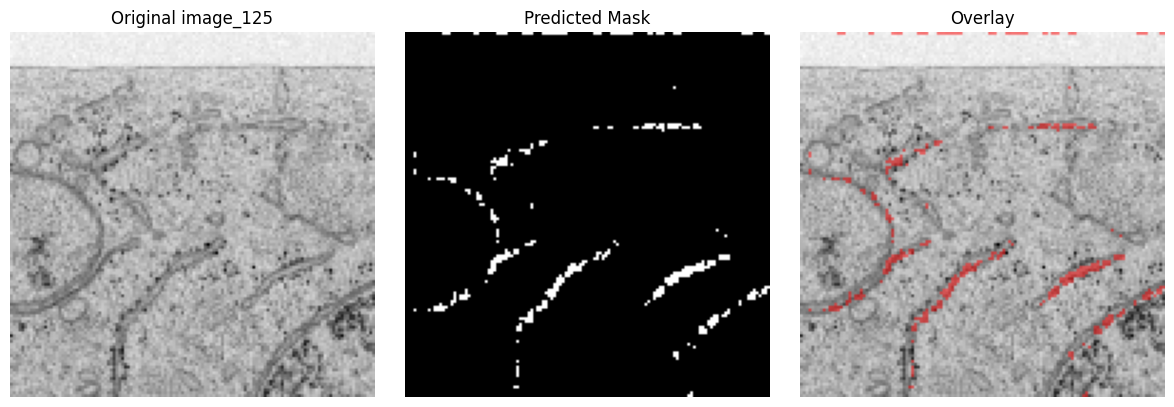


Processing image_171...
ERNet IoU for image_171: 0.0990


2025-09-30 12:34:34,003 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Fidelity" (Weight: 0.3): 5,
    "Appearance Consistency" (Weight: 0.25): 10,
    "Object Completeness" (Weight: 0.25): 5,
    "Background Exclusion" (Weight: 0.2): 30,
    "OverallScore": 11.25
  },
  "Reasons": {
    "Shape Fidelity" (Weight: 0.3): "The segmented regions are extremely small, fragmented, and exhibit highly irregular, jagged contours. They do not form any recognizable biological shapes, let alone the expected tubular, vesicular, or cisternal forms of the endoplasmic reticulum (ER).",
    "Appearance Consistency" (Weight: 0.25): "The tiny red specks are scattered and do not consistently cover areas that visually correspond to the internal lumen or characteristic appearance of ER structures. They appear more like noise or partial boundary detections rather than coherent internal regions.",
    "Object Completeness" (Weight: 0.25): "The segmentation fails to identify nearly all visible structures that could be interpreted as ER, including th

/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/oneshot_segGPT.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chkpt_dir, m

One shot segmentation completed and saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/seggpt_results.png, the mask is saved in seggpt_mask_path:/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/seggpt_results_mask.png.
SegGPT IoU for image_171: 0.0000
→ SegGPT overlay saved to: ./ERNet_results/image_171_seggpt.png


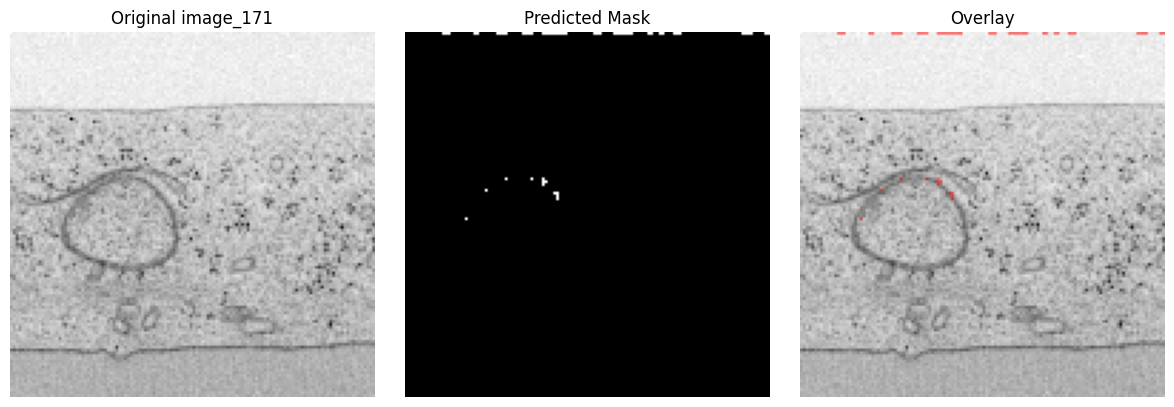


Processing image_45...
ERNet IoU for image_45: 0.0049


2025-09-30 12:35:18,127 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Fidelity" (Weight: 0.3): 5,
    "Appearance Consistency" (Weight: 0.25): 10,
    "Object Completeness" (Weight: 0.25): 0,
    "Background Exclusion" (Weight: 0.2): 5,
    "OverallScore": 5.0
  },
  "Reasons": {
    "Shape Fidelity" (Weight: 0.3): "The segmented regions are predominantly small, fragmented, and highly irregular, failing to produce the smooth, round contours expected for lysosomes. The larger segmented area in the bottom right is also amorphous and not lysosome-shaped. There are very few, if any, segments that exhibit good shape fidelity.",
    "Appearance Consistency" (Weight: 0.25): "Many segmented pixels are scattered in noisy background areas or on the edges of other organelles, not consistently corresponding to the dense, dark, vacuole-like appearance of lysosomes. While the large blob in the bottom right is dense, its overall appearance is not clearly a distinct lysosome.",
    "Object Completeness" (Weight: 0.25): "The segmentation h

/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/oneshot_segGPT.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chkpt_dir, m

One shot segmentation completed and saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/seggpt_results.png, the mask is saved in seggpt_mask_path:/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/seggpt_results_mask.png.
SegGPT IoU for image_45: 0.0047
→ SegGPT overlay saved to: ./ERNet_results/image_45_seggpt.png


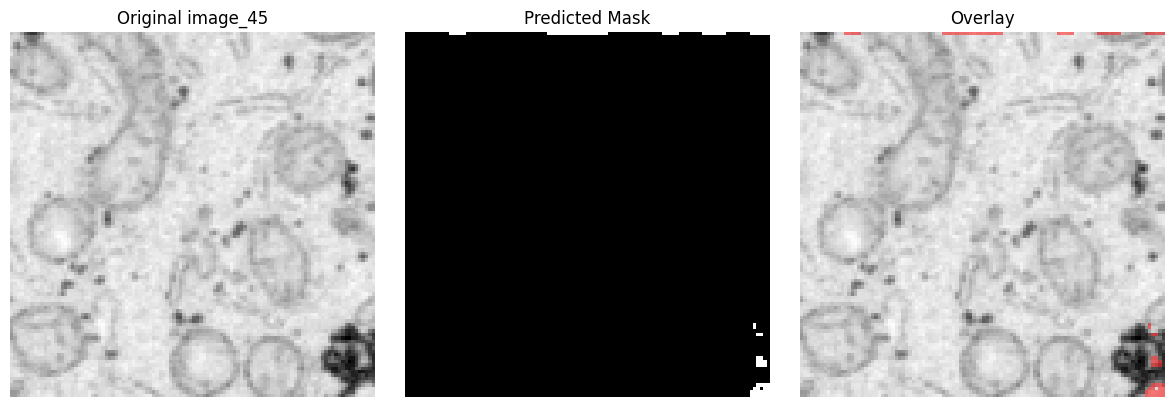


Processing image_49...
ERNet IoU for image_49: 0.0031


2025-09-30 12:36:01,688 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Fidelity" (Weight: 0.3): 15,
    "Appearance Consistency" (Weight: 0.25): 30,
    "Object Completeness" (Weight: 0.25): 25,
    "Background Exclusion" (Weight: 0.2): 10,
    "OverallScore": 20.25
  },
  "Reasons": {
    "Shape Fidelity" (Weight: 0.3): "The segmented regions are highly irregular, jagged, and fragmented. They do not exhibit the smooth, round, or slightly varied spherical contours expected for lysosomes. Many segmented areas appear as small, disconnected specks rather than coherent organelle shapes.",
    "Appearance Consistency" (Weight: 0.25): "While some segmented areas do overlap with darker regions that could potentially be lysosomes, many also cover lighter cytoplasmic areas, edges of other organelles (like mitochondria), or general background. The segmentation is not consistently targeting the 'dense, dark, vacuole-like' structures, and often extends beyond the boundaries of potential lysosomes.",
    "Object Completeness" (Weight: 0

/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/oneshot_segGPT.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chkpt_dir, m

One shot segmentation completed and saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/seggpt_results.png, the mask is saved in seggpt_mask_path:/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/seggpt_results_mask.png.
SegGPT IoU for image_49: 0.0018
→ SegGPT overlay saved to: ./ERNet_results/image_49_seggpt.png


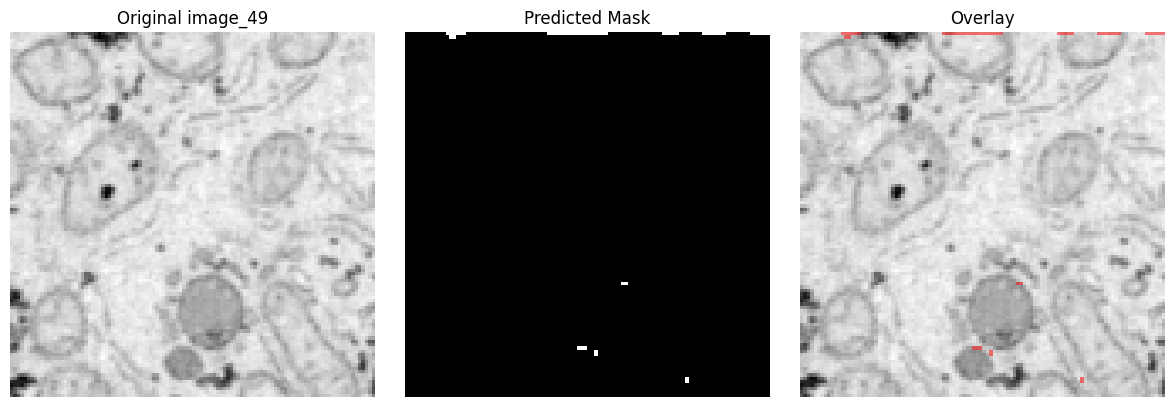


Processing image_77...
ERNet IoU for image_77: 0.0008


2025-09-30 12:36:45,779 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Fidelity" (Weight: 0.3): 45,
    "Appearance Consistency" (Weight: 0.25): 50,
    "Object Completeness" (Weight: 0.25): 60,
    "Background Exclusion" (Weight: 0.2): 25,
    "OverallScore": 46.0
  },
  "Reasons": {
    "Shape Fidelity" (Weight: 0.3): "While the larger segmented objects exhibit reasonably smooth, oval contours that could be consistent with lysosome-like structures, there is a significant number of very small, highly irregular, and jagged segmented regions that do not conform to the expected spherical or slightly varied lysosome shape. These numerous small, poorly shaped segments detract significantly from the overall shape fidelity.",
    "Appearance Consistency" (Weight: 0.25): "The larger segmented regions generally correspond well to dense, dark, 'vacuole-like' structures in the original image, aligning with the expectation of a filled, membrane-bound sac. However, many of the smaller, spurious segmented blobs are located in areas that

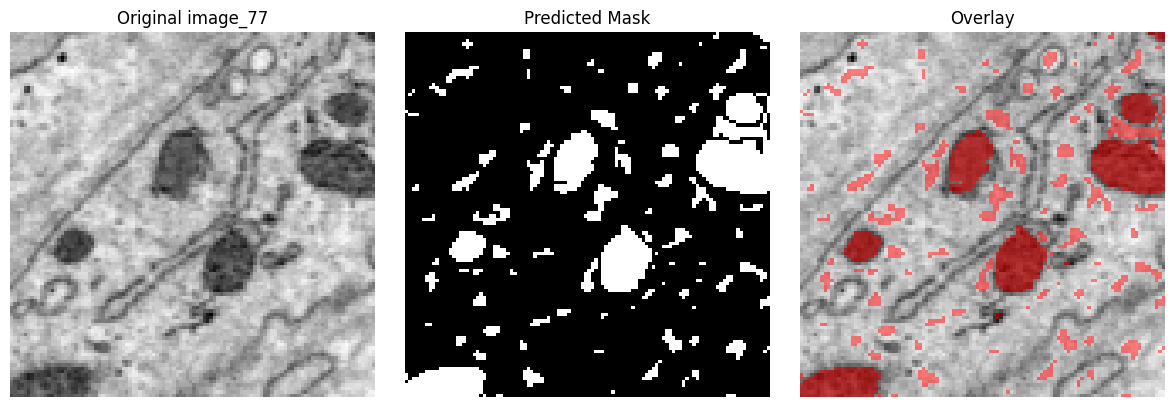


Processing image_85...
ERNet IoU for image_85: 0.0114


2025-09-30 12:37:32,626 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Fidelity" (Weight: 0.3): 15,
    "Appearance Consistency" (Weight: 0.25): 30,
    "Object Completeness" (Weight: 0.25): 20,
    "Background Exclusion" (Weight: 0.2): 10,
    "OverallScore": 19.0
  },
  "Reasons": {
    "Shape Fidelity" (Weight: 0.3): "The segmented regions are predominantly jagged and irregular, failing to produce the smooth, round contours expected for lysosomes. Many segmented areas are fragmented or elongated, not matching the characteristic spherical or slightly varied lysosome shape. The mask's boundaries are pixelated and rough.",
    "Appearance Consistency" (Weight: 0.25): "While some segmented areas do overlap with dense, dark structures that could be lysosome-like, the segmentation is inconsistent. It often covers only parts of these structures and includes many regions that are not dense or dark. The internal appearance is fragmented rather than a consistent 'filled sac'.",
    "Object Completeness" (Weight: 0.25): "The segmen

/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/oneshot_segGPT.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chkpt_dir, m

One shot segmentation completed and saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/seggpt_results.png, the mask is saved in seggpt_mask_path:/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/seggpt_results_mask.png.
SegGPT IoU for image_85: 0.2180
→ SegGPT overlay saved to: ./ERNet_results/image_85_seggpt.png


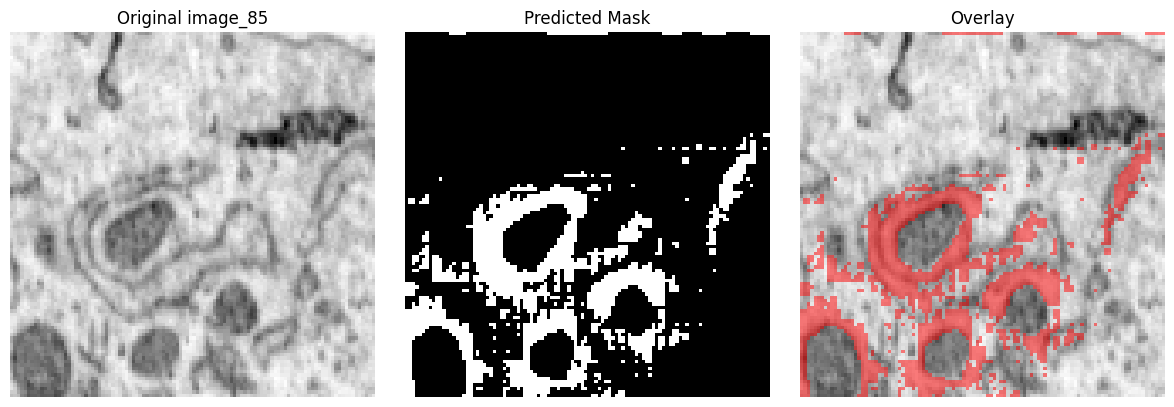


Processing image_86...
ERNet IoU for image_86: 0.0035


2025-09-30 12:38:27,615 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Fidelity" (Weight: 0.3): 30,
    "Appearance Consistency" (Weight: 0.25): 65,
    "Object Completeness" (Weight: 0.25): 35,
    "Background Exclusion" (Weight: 0.2): 20,
    "OverallScore": 38
  },
  "Reasons": {
    "Shape Fidelity" (Weight: 0.3): "The segmented regions exhibit a mix of shapes. While some larger segmented objects are somewhat oval or rounded, many smaller segmented areas are highly irregular, jagged, and do not consistently conform to the expected smooth, spherical, or slightly varied lysosome shape. The overall consistency with the target shape is poor.",
    "Appearance Consistency" (Weight: 0.25): "The segmented areas generally correspond to dense, dark regions in the original image, which aligns with the 'vacuole-like' description for lysosomes. The internal appearance of the segmented regions is consistent with filled, membrane-bound sacs. However, this consistency is applied to structures that are not necessarily lysosomes.",
    

/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/oneshot_segGPT.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chkpt_dir, m

One shot segmentation completed and saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/seggpt_results.png, the mask is saved in seggpt_mask_path:/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/seggpt_results_mask.png.
SegGPT IoU for image_86: 0.2202
→ SegGPT overlay saved to: ./ERNet_results/image_86_seggpt.png


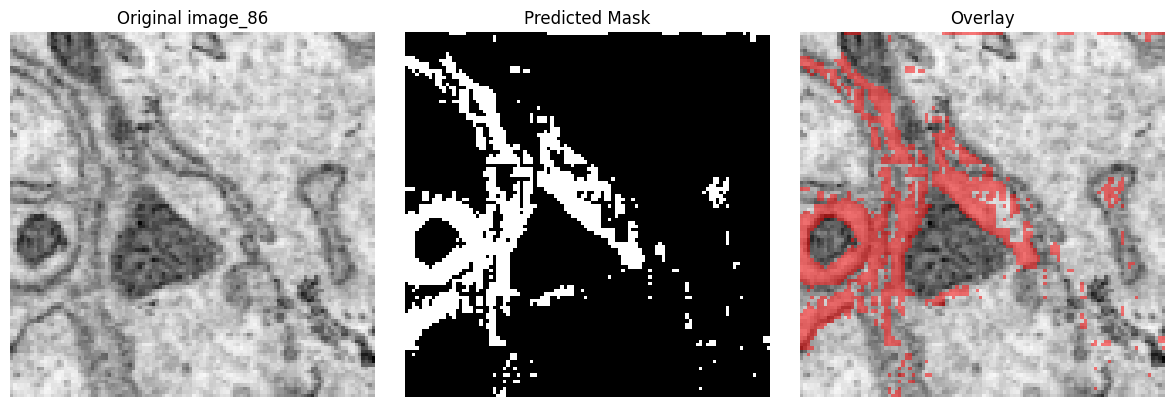


=== IoU Summary ===
Image 1: IoU = 0.2416 (Model: ERNet)
Image 101: IoU = 0.1914 (Model: SegGPT)
Image 109: IoU = 0.2234 (Model: SegGPT)
Image 125: IoU = 0.1501 (Model: SegGPT)
Image 171: IoU = 0.0000 (Model: SegGPT)
Image 45: IoU = 0.0047 (Model: SegGPT)
Image 49: IoU = 0.0018 (Model: SegGPT)
Image 77: IoU = 0.0008 (Model: ERNet)
Image 85: IoU = 0.2180 (Model: SegGPT)
Image 86: IoU = 0.2202 (Model: SegGPT)

Average IoU over 10 images: 0.1252


In [6]:
import matplotlib.pyplot as plt 
from PIL import Image
import numpy as np
from skimage import io
import re
image_index_list = [1, 101, 109, 125, 171, 45, 49, 77, 85, 86]

ernet_mask_img_path = "/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/test_images/er/images/image_{}_out_0000.png"
base_label_path = "/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/test_images/er/labels/label_{}.png"

threshold = 40 #thesold for in-context learning
base_img_path = "/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/test_images/er/images/image_{}.png"
ernet_mask_img_path = "/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/test_images/er/images/image_{}_out_0000.png"
ernet_ouput_path = "/home/idies/workspace/Storage/xyu1/persistent/Langchain/results_improve_exist/ERNet_results/image_{}.png"
evaluation_prompt_path = "/home/idies/workspace/Storage/xyu1/persistent/Langchain/results_improve_exist/in_context_prompt_er.json"
# Function to calculate IoU
def calculate_iou(pred_mask, gt_mask):
    pred_binary = np.array(pred_mask) > 0
    gt_binary = np.array(gt_mask) > 0
    intersection = np.logical_and(pred_binary, gt_binary).sum()
    union = np.logical_or(pred_binary, gt_binary).sum()
    if union == 0:
        return float('nan')
    return intersection / union

ious = []

for i, index in enumerate(image_index_list):
    print(f"\nProcessing image_{index}...")
    image_example_2_path = f"/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/test_images/er/images/image_{index}.png"
    image_example_1_path = f"/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/test_images/er/overlay_all/image_{index}.png"
    
    
    image_path = base_img_path.format(index)
    ground_truth_path = base_label_path.format(index)
    ground_truth_label = Image.open(ground_truth_path).convert('L')
    ernet_mask_path = ernet_mask_img_path.format(index)
    label_path = base_label_path.format(index)

    # Load and binarize predicted mask (ignore label 85)
    mask_pred = io.imread(ernet_mask_path)
    binary_pred = (~np.isin(mask_pred, [85])).astype(np.uint8)
    
    original_img = Image.open(image_path).convert('RGB')
    original_np = np.array(original_img)

    
    pred_mask_np = np.array(binary_pred) > 0
    red_overlay = np.zeros_like(original_np)
    red_overlay[..., 0] = 255  # Red channel

    alpha = 0.5
    overlay_np = np.where(pred_mask_np[..., None],
                          (alpha * red_overlay + (1 - alpha) * original_np).astype(np.uint8),
                          original_np)
    
    
    
  
    
    
    query_img = Image.open(image_path)
    # Load and binarize ground truth mask
    gt_mask = Image.open(label_path).convert('L')
    binary_gt = (np.array(gt_mask) > 0).astype(np.uint8)
    
    gt_mask = np.array(binary_gt) > 0
    red_overlay_gt = np.zeros_like(original_np)
    red_overlay_gt[..., 0] = 255  # Red channel


    overlay_np_gt = np.where(gt_mask[..., None],
                          (alpha * red_overlay + (1 - alpha) * original_np).astype(np.uint8),
                          original_np)
    

    
    iou = calculate_iou(binary_pred, gt_mask)
    print(f"ERNet IoU for image_{index}: {iou:.4f}")
    ernet_output_img_pth = ernet_ouput_path.format(index)
    
    outputs = segmentation_evaluator(ernet_output_img_pth, 
                                     segmentation_prompt,
                                     evaluation_prompt_path,
                                     image_example_1_path,
                                     image_example_2_path)
    print(outputs)
    
    outputs_dict = json.loads(outputs)

    # Get the evaluation data - it could be a string or already a dict
    evaluation_data = outputs_dict["evaluation"]

    # Check if it's already a dictionary or if it's a string that needs parsing
    if isinstance(evaluation_data, dict):
        # It's already a dictionary, extract OverallScore directly
        overall_score = evaluation_data.get("ReviewScore", {}).get("OverallScore")
        if overall_score is not None:
            print(f"OverallScore: {overall_score}")
        else:
            print("OverallScore not found in dictionary structure")
    else:
        # It's a string, use the original parsing logic
        raw_text = evaluation_data

        # Clean the text (remove backticks and extra whitespace)
        cleaned_json = raw_text.strip('`').strip()

        # Remove optional "json" prefix if present
        if cleaned_json.startswith("json"):
            cleaned_json = cleaned_json[len("json"):].strip()

        # Extract the OverallScore using regex
        match = re.search(r'"OverallScore"\s*:\s*(\d+\.?\d*)', cleaned_json)
        if match:
            overall_score = float(match.group(1))
            print(f"OverallScore: {overall_score}")
        else:
            print("OverallScore not found")

    
    if overall_score >= threshold:
        print(f"→ Keeping ERNet result for image_{index} (score = {overall_score:.4f})")
        ious.append((index, iou, "ERNet"))
    else:
        print(f"→ ERNet score too low ({overall_score:.4f}). Switching to SegGPT...")

        # Get best prompt index based on max correlation
        best_prompt_idx = np.argmax(correlation_matrix[i])
        prompt_image_path = prompt_sets[best_prompt_idx]["image"]
        prompt_mask_path = prompt_sets[best_prompt_idx]["mask"]

        # Run inference
        seggpt_inference_img(image_path, prompt_image_path, prompt_mask_path)

        # Load output
        segment_save_path = "/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/seggpt_results.png"
        segment_mask_path = "/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/seggpt_results_mask.png"



        seg_image = Image.open(segment_save_path)
        pred_mask = Image.open(segment_mask_path).convert('L')
        pred_mask_np = np.array(pred_mask)
        iou_seggpt = calculate_iou(pred_mask, ground_truth_label)

        print(f"SegGPT IoU for image_{index}: {iou_seggpt:.4f}")
        ious.append((index, iou_seggpt, "SegGPT"))
        
        # Generate and save overlay
        mask = pred_mask_np > 0
        red_overlay = np.zeros_like(original_np)
        red_overlay[..., 0] = 255
        overlay_np = np.where(mask[..., None],
                              (alpha * red_overlay + (1 - alpha) * original_np).astype(np.uint8),
                              original_np)
        seggpt_overlay_path = os.path.join(output_dir, f"image_{index}_seggpt.png")
        Image.fromarray(overlay_np).save(seggpt_overlay_path)
        print(f"→ SegGPT overlay saved to: {seggpt_overlay_path}")
        
        
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(original_np)
    plt.title(f"Original image_{index}")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask_np, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay_np)
    plt.title("Overlay")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Summary
print("\n=== IoU Summary ===")
for idx, iou_val, model in ious:
    print(f"Image {idx}: IoU = {iou_val:.4f} (Model: {model})")

mean_iou = np.nanmean([val for _, val, _ in ious])
print(f"\nAverage IoU over {len(ious)} images: {mean_iou:.4f}")

